# Posprocessing a run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=.6
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [3]:
import lenses
import jax
import numpy as np
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from tqdm import trange

from flox.util import key_chain
from flox.flow import Pipe, Inverted, bind#, Transform, Transformed
import equinox as eqx
from functools import partial

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

chain = key_chain(42)

2023-03-01 14:03:43.335298: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-03-01 14:03:43.335388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-03-01 14:03:43.335395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [5]:
def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

In [6]:
# logdir_path = "../jonas_logdir/"
# logdir_path += 'tuna_N16_T100_noaux_2023-01-24_16:02:39' #ESS 22.12% internally coherent ------------------
# logdir_path += 'antelope_N16_T50_noaux_2023-01-25_08:08:54' #ESS 4.80% ------------------
# logdir_path += 'dragonfly_N128_T100_noaux_2023-01-24_22:33:59' #ESS 0.25% ------------------

#######################################################################################################

logdir_path = "../logdir/"
# logdir_path += 'antelope_N128_T100_std_2023-02-27_16:17:18'

# folder = !ls -d {logdir_path}antelope_N128_T100_std*
folder = !ls -d {logdir_path}tuna_N16_T100_std*
logdir_path = folder[-1]

#######################################################################################################

# logdir_path = "../testing"

#######################################################################################################

stage = !ls -d {logdir_path}/training_stage* |wc -l
stage = int(stage[0]) - 1
epoch = !ls -d {logdir_path}/training_stage_{stage}/epoch_* |wc -l
epoch = int(epoch[0]) - 1
print(f"+++ trainng stage {stage}, epoch {epoch} +++")
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f"{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx"
print(pretrained_model_path)

+++ trainng stage 0, epoch 9 +++
../logdir/tuna_N16_T100_std_2023-03-01_13:43:53/training_stage_0/epoch_9/model.eqx


In [7]:
specs = ExperimentSpecification.load_from_file(specs_path)
specs = lenses.bind(specs).model.base.path.set(specs.model.base.path + "/eval_100")

base = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.base)
model = base.omm_model.model

training_data_size = 100_000 if specs.model.base.num_samples is None else specs.model.base.num_samples
print(f"MD training datapoints = {training_data_size:_}")
print(f"MD eval datapoints = {base.data.pos.shape[0]:_}")
print(f"batchs per epoch = {specs.train[0].num_iters_per_epoch}")
print(f"batch size = {specs.train[0].num_samples}")
print(f"data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/training_data_size}")

MD training datapoints = 100_000
MD eval datapoints = 100_000
batchs per epoch = 500
batch size = 32
data fraction: 1.6


In [8]:
try:
    ref_file = f"../data/water/DeltaF_estimates/DF-{specs.model.base}-{specs.model.target}.txt"
    reference_deltaF, reference_deltaF_std = np.loadtxt(ref_file, unpack=True)
except FileNotFoundError:
    reference_deltaF, reference_deltaF_std = None, None

reference_deltaF, reference_deltaF_std

(-666.09898, 0.05976)

In [19]:
sc = model.n_molecules
test_subplots = True

In [32]:
try:
    loss = np.loadtxt(logdir_path+'/loss.txt')
    loss_info = np.stack([1+np.arange(len(loss)), loss], axis=-1)
except FileNotFoundError:
    import json
    with open(logdir_path+'/loss.json', "r") as f:
        loss_info = np.array(json.load(f))[:,1:]

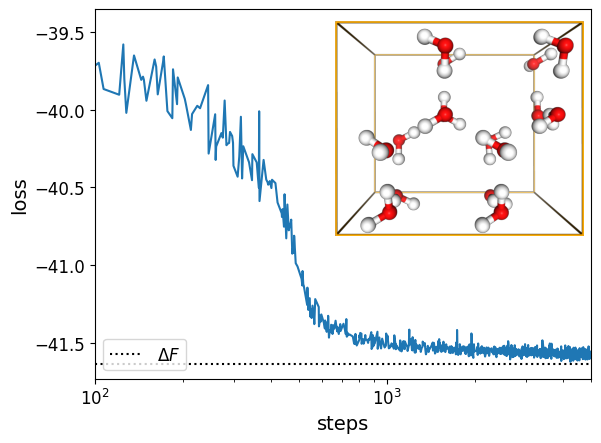

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

def plot_loss(label_txt=None):
    plt.plot(loss_info[:,0], loss_info[:,1]/sc)
    plt.axhline(reference_deltaF/sc, c='k', ls=':', label='$\Delta F$')
    plt.xlim(1e2, loss_info[-1,0])
    plt.xscale('log')
    plt.ylabel('loss')
    plt.xlabel('steps')
    plt.legend(loc='lower left')

    if label_txt is not None:
        plt.text(-0.2, 1.0, label_txt, transform=plt.gca().transAxes, fontdict={'fontsize': 'large'})
    
    img = mpimg.imread(f'../data/water/iceXI-N{model.n_molecules}.png')
    subax = inset_axes(plt.gca(), width="50%", height="60%", loc=1)
    subax.imshow(img)
    subax.axis('off')
    
if test_subplots:
    plot_loss()
    plt.show()

num_samples=100_000
sample base
map base
tot flow parameters: 290_896
compute weights
sample target


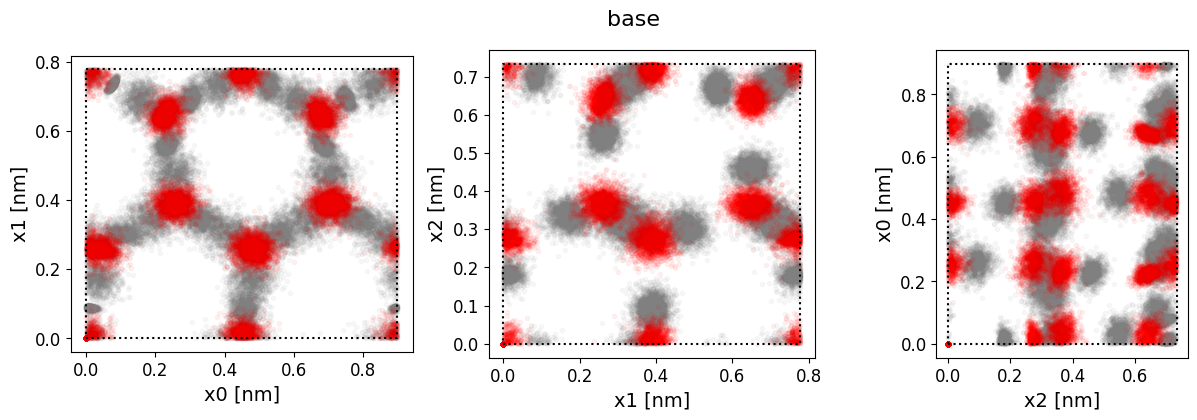

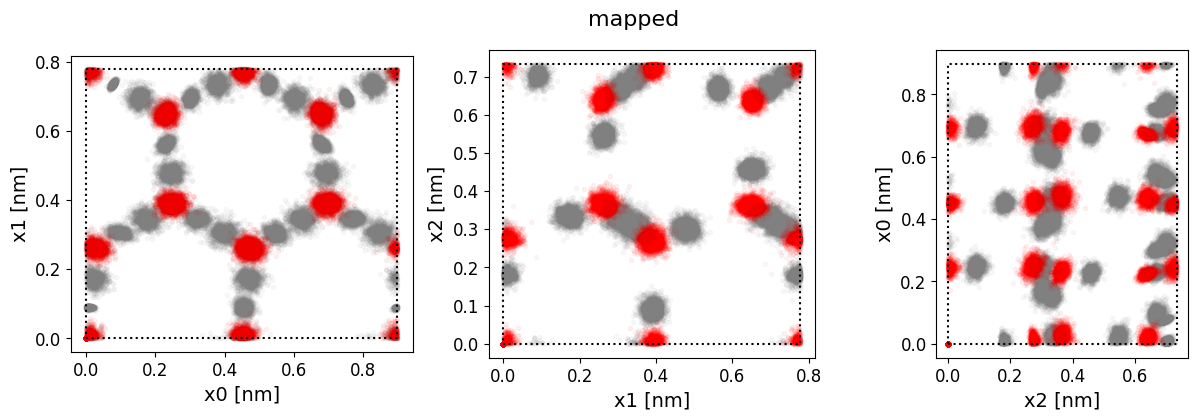

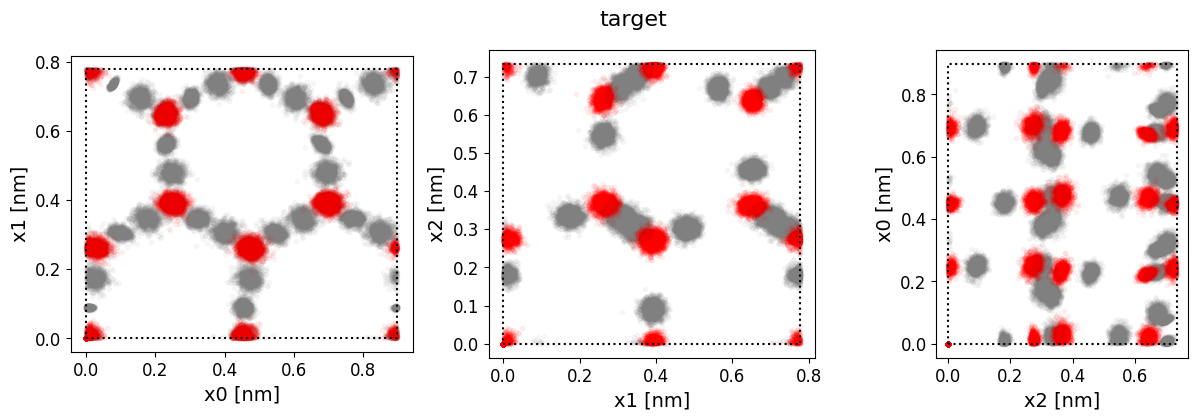

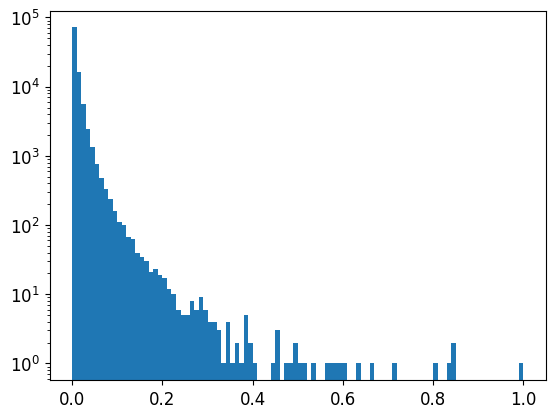

ESS = 20633.9  ->  20.63%
Estimated deltaF from LFEP = -41.6264
          Reference deltaF = -41.6312


In [12]:
recompute = True
datafilename = logdir_path+'/fig-data'

try:
    if recompute:
        raise FileNotFoundError
    data = np.load(datafilename+'.npz')
    base_pos = data['base_pos']
    base_ene = data['base_ene']
    mapped_pos = data['mapped_pos']
    mapped_ene = data['mapped_ene']
    target_pos = data['target_pos']
    target_ene = data['target_ene']
    weights = data['weights']
    
except FileNotFoundError:
    num_samples = base.data.pos.shape[0]
    print(f'num_samples={num_samples:_}')
    def jitvmap(fn, batch_size=512):
        if batch_size is None:
            return jax.jit(jax.vmap(fn))
        else:
            return jax.jit(scanned_vmap(fn, batch_size))

    print('sample base')
    keys = jax.random.split(next(chain), num_samples)
    base_tr = jitvmap(base.sample_idx)(keys, jnp.arange(num_samples))
    base_pos = np.array(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    base_ene = np.array(base_tr.ldj * base.omm_model.kbT)

    print('map base')
    flow = build_flow(
        next(chain),
        specs.model.base.num_molecules,
        specs.model.use_auxiliary,
        specs.model.flow,
    )
    flow = cast(
        Pipe[DataWithAuxiliary, RigidWithAuxiliary],
        eqx.tree_deserialise_leaves(pretrained_model_path, flow),
    )
    print(f"tot flow parameters: {count_params(flow):_}")
    mapped_tr = jitvmap(flow.forward)(base_tr.obj)
    mapped_pos = np.array(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))

    print('compute weights')
    target = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.target)
    ## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
    mapped_ene_tg = jitvmap(target.potential)(mapped_tr.obj)
    mapped_ene = np.array(mapped_ene_tg * target.omm_model.kbT)

    logw = base_tr.ldj + mapped_tr.ldj - mapped_ene_tg
    weights = np.array(jnp.exp(logw-jax.scipy.special.logsumexp(logw)))

    print('sample target')
    keys = jax.random.split(next(chain), num_samples)
    target_tr = jitvmap(target.sample_idx)(keys, jnp.arange(num_samples))
    target_pos = np.array(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))
    target_ene = np.array(target_tr.ldj * target.omm_model.kbT)

    def plot_2Dview(data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 100):
        model.plot_2Dview(data_tr.obj.pos.reshape(-1, model.n_atoms, 3)[::skip], toPBC=toPBC, title=title)

    plot_2Dview(base_tr, title='base')
    plot_2Dview(mapped_tr, title='mapped')
    plot_2Dview(target_tr, title='target')

    plt.hist(jnp.exp(logw - logw.max()), bins=100)
    plt.yscale('log')
    plt.show()
    print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

    ## TFEP
    deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
    print(f'Estimated deltaF from LFEP = {deltaF/sc:g}')
    if reference_deltaF is not None:
        print(f'          Reference deltaF = {reference_deltaF/sc:g}')

In [13]:
# bins = np.linspace(target_ene.min(), np.percentile(base_ene, 99.9), 200)/sc
# if model.n_molecules == 16:
#     bins = np.linspace(-20.5, -17, 200)*model.n_molecules*3/sc
# if model.n_molecules == 128:
#     bins = np.linspace(-20, -17.75, 200)*model.n_molecules*3/sc
bins = np.linspace(-20.5, -17.5, 100)*model.n_molecules*3/sc
hist_kwargs = {"bins": bins, "density": True, "alpha": 0.5}

def plot_energy():
    plt.hist(base_ene/sc, **hist_kwargs, label='base')
    plt.hist(mapped_ene/sc, **hist_kwargs, label='mapped')
    plt.hist(target_ene/sc, **hist_kwargs, label='target')
    if model.n_molecules == 128: #ESS is small, histogram resolution must be smaller
        mybins = 75
    else:
        mybins = hist_kwargs['bins']
    plt.hist(mapped_ene/sc, weights=weights, label='reweighted', bins=mybins, density=True, histtype='step')
    plt.xlabel('potential energy / N [kJ/mol]')
    # plt.xticks(np.arange(-21,-16)*model.n_molecules*3/sc)
    plt.xlim(bins[0], bins[-1])
    plt.ylabel('density')
    plt.legend()

if test_subplots:
    plot_energy()
    plt.show()

In [14]:
import mdtraj as md

n_bins = 200
# r_range = [0.2, min(np.round(np.diag(model.box).min() * 10) / 10, 1)]
r_range = [0.2, 0.7]
ij = model.mdtraj_topology.select_pairs("name == O", "name == O")

base_rdf = md.compute_rdf(model.get_mdtraj(base_pos), ij, r_range=r_range, n_bins=n_bins)
mapped_rdf = md.compute_rdf(model.get_mdtraj(mapped_pos), ij, r_range=r_range, n_bins=n_bins)
target_rdf = md.compute_rdf(model.get_mdtraj(target_pos), ij, r_range=r_range, n_bins=n_bins)

In [15]:
#TODO add reweighted rdf

def plot_rdf():
    plt.plot(*base_rdf, label='base', lw=2)
    plt.plot(*mapped_rdf, label='mapped', lw=4, ls='--')
    plt.plot(*target_rdf, label='target', lw=2)
    # plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
    plt.ylabel("g(r)")
    plt.xlabel("r [nm]")
    plt.xlim(r_range)
    plt.yticks(np.arange(0, 14, 2))
    plt.ylim(None, 13)
    plt.ylabel("oxygen g(r)")
    # plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.legend()

if test_subplots:
    plot_rdf()
    plt.show()

## create the figure

In [18]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plot_loss('a)')

plt.subplot(1, 3, 2)
plot_energy()

plt.subplot(1, 3, 3)
plot_rdf()
ax = plt.gca().twinx()
ax.set_ylabel(f'N={model.n_molecules}, T={specs.model.target.temperature} K', fontsize='x-large')
ax.set_yticks([])

filename = f'ice_results-N{model.n_molecules}_T{specs.model.target.temperature}.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

ValueError: math domain error

Error in callback <function _draw_all_if_interactive at 0x7f195c1a5360> (for post_execute):


ValueError: math domain error

ValueError: math domain error

<Figure size 1500x300 with 5 Axes>

In [ ]:
save_data = True

## backup and save figure
!bck.meup.sh {logdir_path}/{filename}
!cp {filename} {logdir_path}/{filename}

## store all useful data
if save_data:
    np.savez(
        datafilename, 
        base_ene=base_ene, 
        mapped_ene=mapped_ene, 
        target_ene=target_ene, 
        weights=weights, 
        base_pos=base_pos, 
        mapped_pos=mapped_pos, 
        target_pos=target_pos
    )

## configurations

In [ ]:
save_figure = False

def plot_proj(pos, title='', marker='.', alpha=0.2, av_box=model.box):
    mypos = pos % np.diagonal(av_box)
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i in range(3):
        ii = (i + 1) % 3
        iii = (i + 2) % 3
        plt.subplot(1, 3, 1 + i)

        # draw particles
        plt.scatter(
            mypos[..., 1 :: model.n_sites, i],
            mypos[..., 1 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., 2 :: model.n_sites, i],
            mypos[..., 2 :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="gray",
            rasterized=True
        )
        plt.scatter(
            mypos[..., :: model.n_sites, i],
            mypos[..., :: model.n_sites, ii],
            marker=marker,
            alpha=alpha,
            c="r",
            rasterized=True
        )

        def get_label(j):
            match j:
                case 0: 
                    return 'x'
                case 1:
                    return 'y'
                case 2:
                    return 'z'

        plt.xlabel(f"{get_label(i)} [nm]")
        plt.ylabel(f"{get_label(ii)} [nm]")
        plt.xlim(0, av_box[i,i])
        plt.ylim(0, av_box[ii,ii])
        plt.gca().set_aspect(1)
    # plt.show()

plot_proj(base_pos[::1000], 'base')
if save_figure:
    plt.savefig('ice_config-base.pdf', bbox_inches='tight')
plt.show()
plot_proj(mapped_pos[::1000], 'mapped')
if save_figure:
    plt.savefig('ice_config-mapped.pdf', bbox_inches='tight')
plt.show()
plot_proj(target_pos[::1000], 'target')
if save_figure:
    plt.savefig('ice_config-target.pdf', bbox_inches='tight')
plt.show()